# 4. MLP応用 解説
## 概要
本演習ではChapter04で学習した、深層学習の基礎である多層パーセプトロン(応用)を穴埋め形式で実装しました。<br>
演習問題文は<font color="Red">赤字</font>で表示されています。<br>

> テーマ
>> **正則化**: MNIST<br>
>> **データ拡張**: rabbit.jpg<br>
>> [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)を利用します。<br>

## ライブラリのインポート

必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

## データの読み込み

データは前回と同様にMNISTです。

ただし、scikit-learnではなくPyTorchから呼び出すので、使用する関数や引数は異なります。

In [2]:
root = os.path.join('~', '.torch', 'mnist') #MNISTを呼び出すためのパスを指定
transform = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1)])  #読み込んだMNISTデータをテンソル(tensor)型に変形
mnist_train = datasets.MNIST(root=root,
                                download=True,
                                train=True,
                                transform=transform) #学習データの呼び出し
mnist_test = datasets.MNIST(root=root,
                            download=True,
                            train=False,
                            transform=transform) #テスト用データの呼び出し

このデータセット```mnist_train```の中身を見てみましょう。

In [3]:
print(mnist_train[0])

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000,

このように、単一のデータ```mnist_train[0]```には、784次元のテンソルと数字のラベルが入っています。

これらは切り分けて表示することもできます。

In [4]:
print(mnist_train[0][0]) #テンソルデータ全体

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [5]:
print(mnist_train[0][1]) #ラベルデータ

5


### データローダー(Dataloader)の役割

前回まではMNISTを読み込んでreshapeした後に可視化したり、データとして活用したりしていました。

Pytorchでは、MNISTの読み込み後にDataloaderというツールを使用します。

これは簡単に言うと「データセットを指定したバッチサイズに分割してくれるツール」で、PyTorchを使用した学習では頻繁に使われます。

In [6]:
train_dataloader = DataLoader(mnist_train,
                                batch_size=100,
                                shuffle=True)
test_dataloader = DataLoader(mnist_test,
                                batch_size=100,
                                shuffle=False)

#### データローダーの中身

それではデータローダーの中身を見てみましょう。

データローダーはインスタンス化されているため、中身を見るには少々工夫が必要になります。

まず```train_dataloader.__iter__()```で「各バッチに対応するオブジェクトの集合体」を受け取ります。これが```tmp```です。

In [7]:
tmp = train_dataloader.__iter__()
print(tmp)

次に```tmp.next()```で、各バッチごとのデータを見ることができます。

実行するごとに次のバッチに移っていくので、あるバッチの中身を見たい場合は適宜変数に格納していくと良いでしょう。

In [8]:
batch1 = next(tmp)
print(batch1)

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 8, 9, 4, 7, 0, 4, 5, 1, 7, 1, 4, 7, 2, 9, 0, 9, 1, 5, 1, 8, 6, 8, 6,
        2, 3, 4, 3, 4, 4, 6, 5, 9, 3, 9, 4, 7, 1, 3, 2, 8, 7, 7, 7, 9, 0, 8, 6,
        1, 3, 9, 9, 5, 0, 7, 6, 8, 7, 4, 6, 5, 3, 0, 1, 6, 5, 6, 2, 3, 2, 6, 2,
        1, 5, 1, 2, 2, 0, 3, 2, 3, 7, 4, 6, 7, 4, 4, 9, 4, 5, 6, 9, 6, 5, 2, 7,
        2, 0, 2, 7])]


これもテンソルデータとラベルデータが一緒になっているので、リスト指定で切り分けることができます。

In [9]:
batch1[0] #第1バッチのテンソルデータ全体(100個)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [10]:
batch1[0][0] #第1バッチの1個目のテンソル

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [11]:
batch1[1] #第1バッチのラベルデータ全体(100個)

tensor([5, 8, 9, 4, 7, 0, 4, 5, 1, 7, 1, 4, 7, 2, 9, 0, 9, 1, 5, 1, 8, 6, 8, 6,
        2, 3, 4, 3, 4, 4, 6, 5, 9, 3, 9, 4, 7, 1, 3, 2, 8, 7, 7, 7, 9, 0, 8, 6,
        1, 3, 9, 9, 5, 0, 7, 6, 8, 7, 4, 6, 5, 3, 0, 1, 6, 5, 6, 2, 3, 2, 6, 2,
        1, 5, 1, 2, 2, 0, 3, 2, 3, 7, 4, 6, 7, 4, 4, 9, 4, 5, 6, 9, 6, 5, 2, 7,
        2, 0, 2, 7])

In [12]:
batch1[1][0] #第1バッチの1個目のラベルデータ

tensor(5)

## 正則化（PyTorch）

### ドロップアウト
ドロップアウトとは、学習時に指定された割合のノードをランダムに消すテクニックであり、部分的なネットワークのアンサンブル学習として捉えることができます。これによって、表現力が高いMLPにおいても過学習を抑制することが可能になる場合あります。

ここでは、ドロップアウトのクラスをNumPyライブラリを用いて実装します。


<font color="Red">問1. 生成したrandommatrixがself.dropout_ratioより大きければTrue、そうでなければFalseを返すマスクを生成しましょう。</font><br>

In [13]:
class Dropout():
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def __call__(self, x, train_flg=True):
        if train_flg:
            randommatrix = np.random.rand(*x.shape)
            self.mask = #### 問1 ####
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

### <font color="Red">ガイド</font>

#### マスキング操作とマスク

まず、マスキング操作とマスクについて説明します。

マスキング操作とは、**ブール配列(Boolean array)**
を利用して、ある配列の特定の部分のみを書き換えたり、抽出したりする操作です。

このとき使用するブール配列を**マスク**と呼びます。


#### ブール配列とは

ブール配列とは、ブール値(True/False)のみを値に持つ配列のことです。

配列に対して何らかの条件式(<,>,=など)を適用することで生成できます。

例えば行列```x```を以下のように定義したとします。

$$x=\left(
\begin{array}{cc} 
1 & -7 \\ -1 & 5 
\end{array}
\right)$$

In [14]:
x = np.array([[1,-7],[-1,5]])
print(x)

[[ 1 -7]
 [-1  5]]


この場合、```mask = (x <= 0)```を考慮すると、```mask```は以下の通りになります。

$$mask=\left(
\begin{array}{cc} 
False & True \\ True & False 
\end{array}
\right)$$

In [15]:
mask = (x <= 0)
print(mask)

[[False  True]
 [ True False]]


このように、条件```(x<=0)```に沿っているかどうかをTrue・Falseで返す配列がmaskとなります。

配列のリスト指定でmaskを使うと、Trueの部分に対して抽出やデータの書き換えができるようになります。

今回は、0以下の数値を全て0に変換するように操作してみましょう。

In [16]:
x * mask

array([[ 0, -7],
       [-1,  0]])

In [17]:
x[mask] = 0
print(x)

[[1 0]
 [0 5]]


このように、maskにより条件に合うデータをまとめて操作できました。

今回の操作はif文やfor文の組み合わせも可能ですが、maskの方が簡潔に記述できます。

また、条件が複数の場合にも、maskを複数生成することで、整理しつつデータの書き換えや抽出ができます。

#### 問1再訪 

話を問1に戻します。この場合、「randommatrixがself.dropout_ratioより大きければTrue」というmaskを作ることになりますね。

```randommatrix = np.random.rand(*x.shape)```より、randommatrixは入力データxと同じ形状を持つ配列となります。

今回はxをMNISTの最初のデータにして試してみましょう。

In [18]:
x = batch1[0][0]
randommatrix = np.random.rand(*x.shape)
print(randommatrix)

[0.47947399 0.05456009 0.45427267 0.25570792 0.43221983 0.08927844
 0.59759819 0.33689921 0.63186399 0.72632331 0.88395414 0.96859894
 0.86336762 0.90123926 0.25289113 0.13929965 0.23247277 0.6729501
 0.05872177 0.79609264 0.28752855 0.22244515 0.62218432 0.98022433
 0.91932619 0.54858359 0.50537901 0.3215312  0.02282493 0.75926828
 0.04123183 0.99748404 0.28043665 0.12103925 0.80283418 0.34058299
 0.04028109 0.41692931 0.34246284 0.98082248 0.89724299 0.66721472
 0.15495149 0.92921833 0.66001297 0.07640174 0.3923385  0.32434908
 0.24423225 0.39529105 0.78585492 0.40905241 0.28115812 0.41132266
 0.34366077 0.77587409 0.38752834 0.87524347 0.03415137 0.62981734
 0.72470398 0.17749907 0.69212875 0.19128181 0.15595669 0.38806339
 0.04256039 0.45156087 0.51839699 0.95200094 0.05109949 0.37522327
 0.33366577 0.04968944 0.41529786 0.70593045 0.63073685 0.05434361
 0.84660247 0.99236686 0.11659238 0.55200229 0.86825178 0.22080684
 0.99444359 0.90105311 0.25395647 0.79004251 0.94028626 0.88691

In [19]:
print(randommatrix.shape)

(784,)


このように```np.random.rand```は0以上1以下の数値を持つ配列となります。配列の次元は引数で指定します。

これに対し、問題コードより```self.dropout_ratio=0.5```なので、```randommatrix```の中で0.5より大きい要素をTrueにして返すようなブール配列を作成すればOKですね。

それでは条件式でこのブール配列を書いてみましょう。

それをコード形式に合わせて転記すれば、問1のコードを動かせるはずです。

---------------------------

### Dropout実装

PyTorchでDropoutを実装する場合、`torch.nn.Dropout()`が用いられます。

* <font color="Red">問2. PyTorchでDropoutを実装しましょう。</font>
  * <font color="Red">問2-1. 確率 `0.5` で出力を0にするDropoutのインスタンスを生成しましょう。</font>
  * <font color="Red">問2-2. 入力`input` に対しDropoutを適用する処理を記述しましょう。</font>


In [20]:
torch.manual_seed(0)
input = torch.randn(3, 4)
print('入力: \n', input)

m = ### 問2-1 ###
output = ### 問2-2 ###
print('Dropout後の出力: \n', output)

入力: 
 tensor([[ 1.5410, -0.2934, -2.1788,  0.5684],
        [-1.0845, -1.3986,  0.4033,  0.8380],
        [-0.7193, -0.4033, -0.5966,  0.1820]])
Dropout後の出力: 
 tensor([[ 3.0820, -0.0000, -4.3576,  1.1369],
        [-2.1690, -2.7972,  0.0000,  0.0000],
        [-1.4385, -0.0000, -1.1933,  0.0000]])


### <font color="Red">ガイド</font>

まず問2-1について、Dropoutのインスタンスはpytorchのライブラリに含まれている```torch.nn.Dropout```を用いることで実装できます。

また、引数の1つとして```p```というものがあり、出力を0にする割合を0~1の間の数値で指定することができます。

次に問2-2です。問2-1によりDropoutのインスタンスを生成できたため、入力に対してDropoutを適用する処理を作成します。

問2-1でインスタンスを作成したので、これを関数として取り扱い```input```を入力することで、Dropoutを適用することができます。

参考リンク(英語)：https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

-------------------------

## パラメータノルムペナルティ

ノルムペナルティとは、モデルのパラメータが学習時に極端な値を取らないよう制限をかける手法です。

下記の式のように、損失関数にパラメータのLpノルム$||w||_{p}$を加えます。

$$
L_{norm}(y(X), t) = L(y(X), t) + \lambda||w||_{p}
$$

まずはLpノルム$||w||_{p}$を算出する関数を実装しましょう。

* <font color="Red">問3. Lpノルムを算出する関数を完成させてください。</font>

In [21]:
def lp_norm(w, p=2):
    return ### 問3 ###

### <font color="Red">ガイド</font>

今回求めたのは、$||w||_{p}$ですが、これは次のように求めることができます。

$$ ||w||_{p} = (|w_{1}|^p + |w_{2}|^p + ... +|w_{n}|^p)^\frac{1}{p} $$

まず、絶対値はpytorchのライブラリにある```torch.abs```を用いて、```torch.abs(w)**p```で表すことができます。

次に、絶対値の和の部分は、pytorchのライブラリにある```torch.sum```を用いて、```torch.sum(torch.abs(w)**p)```と表すことができます。

最後に、絶対値の和を$\frac{1}{p}$乗すれば良いので、これらを組み合わせると正しいコードになります。

---------------

次に、ラッソの損失を算出する関数を実装しましょう。

ラッソの損失はL1ノルムを用いて、下記の式のように定義されます。

$$
L_{norm}(y(X), t) = L(y(X), t) + \lambda\sum_{n=1}^D{|{w_n}|}
$$

* <font color="Red">問4. L1ノルム付き損失関数の第2項、$\lambda\sum_{n=1}^D{|w_n|}$の部分を算出する関数を完成させてください。</font>

In [22]:
def Lasso_loss(net, lam=0.001):
    loss = 0
    for params in net.parameters():#net.parameters()はネットワークの各層のパラメータを意味する
        loss += ### 問4 ###
    return lam * loss

### <font color="Red">ガイド</font>

Lasso損失関数の第2項、$\lambda\sum_{n=1}^D{|w_n|}$をコードで実装できれば答えとなります。

第1項の$L(y(X), t)$は```loss```という変数で表現されていて、$\lambda$を掛ける処理はreturnの```lam * loss```で表現されています。

よって、$\sum_{n=1}^D{|w_n|}$の部分をコーディングします。

ここで、$w_n$というのはネットワークの各層ごとのパラメータ、つまり```params```を表します。

```net.parameters()```でパラメータ一覧のリストを取得し、それをfor文で1つ1つ```params```として取り出す構造になっています。

<br>

$w_n$の絶対値は```torch.abs(params)```と表すことができます。求めたいのはこれの総和($\Sigma$)なので、```torch.sum```が使えます。

また、この計算はネットワークの1層目～n層目のパラメータについて行うため、```loss```という変数に値を加えていく必要があります。

これらを組み合わせればコードを導けるはずです。

---------------

次に、リッジ回帰を算出する関数を実装しましょう。

L2ノルム付き損失関数はL2ノルムを用いて、下記の式のように定義されます。

$$
L_{norm}(y(X), t) = L(y(X), t) + \frac{\lambda}{2}\sqrt{{\sum_{n=1}^D{w_n^2}}}
$$

* <font color="Red">問5.  L2ノルム付き損失関数の$\frac{\lambda}{2}\sqrt{{\sum_{n=1}^D{w_n^2}}}$を算出する関数を完成させてください。</font>

In [23]:
def Ridge_loss(net, p=2, lam=0.001):
    loss = 0
    for params in net.parameters():#net.parameters()はネットワークの各層のパラメータを意味する
        loss += ### 問5 ###
    return (1/2) * lam * loss

### <font color="Red">ガイド</font>

今回求めたい部分は、L2ノルム付き損失関数の$\sqrt{{\sum_{n=1}^D{w_n^2}}}$の部分です。

まず、$w^2$について考えます。$w$は```params```と表されているため、$w^2$は、事前に準備されている```p=2```を用いて、```torch.abs(params)**p```と表されます。

今回求めたい部分は、```torch.abs(params)**p```の総和のルートであるため、```torch.sum```と```**```(累乗)を使えばOKですね。

ルートの処理は式全体の$\frac{1}{2}=\frac{1}{p}$乗であることを利用しましょう。

これを、ネットワークの各層のパラメータごとに足す必要があるため、```loss```に```torch.sum(torch.abs(params)**p) ** (1/p)```分だけ付け加える必要があります。

-------------

## ドロップアウトとL2ノルム正則化を含めたMLPの実装 (<u>ライブラリを使用しない</u>)

### 線形結合層などの定義

chapter02,chapter03演習のコードをPyTorchを用いて実装しているものであり、読み飛ばしていただいて構いません。

In [24]:
# nn.Linearではなく、スクラッチの際に使用
class FullyConnectedLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FullyConnectedLayer, self).__init__()
        self.in_features = input_dim  # 入力値の次元
        self.out_features = output_dim  # 出力値の次元

        weight = torch.randn(input_dim, output_dim) * 0.01
        bias = torch.randn(output_dim) * 0.01

        self.weight = nn.parameter.Parameter(weight)
        self.bias = nn.parameter.Parameter(bias)

    def forward(self, x):
        x = torch.mm(x, self.weight) + self.bias
        return x

In [25]:
# nn.ReLUではなく、スクラッチの際に使用
class ReLU(nn.Module):
    def __init__(self):
        super(ReLU, self).__init__()
    
    def forward(self,x):
        mask = (x <= 0)
        x[mask] = 0
        return x

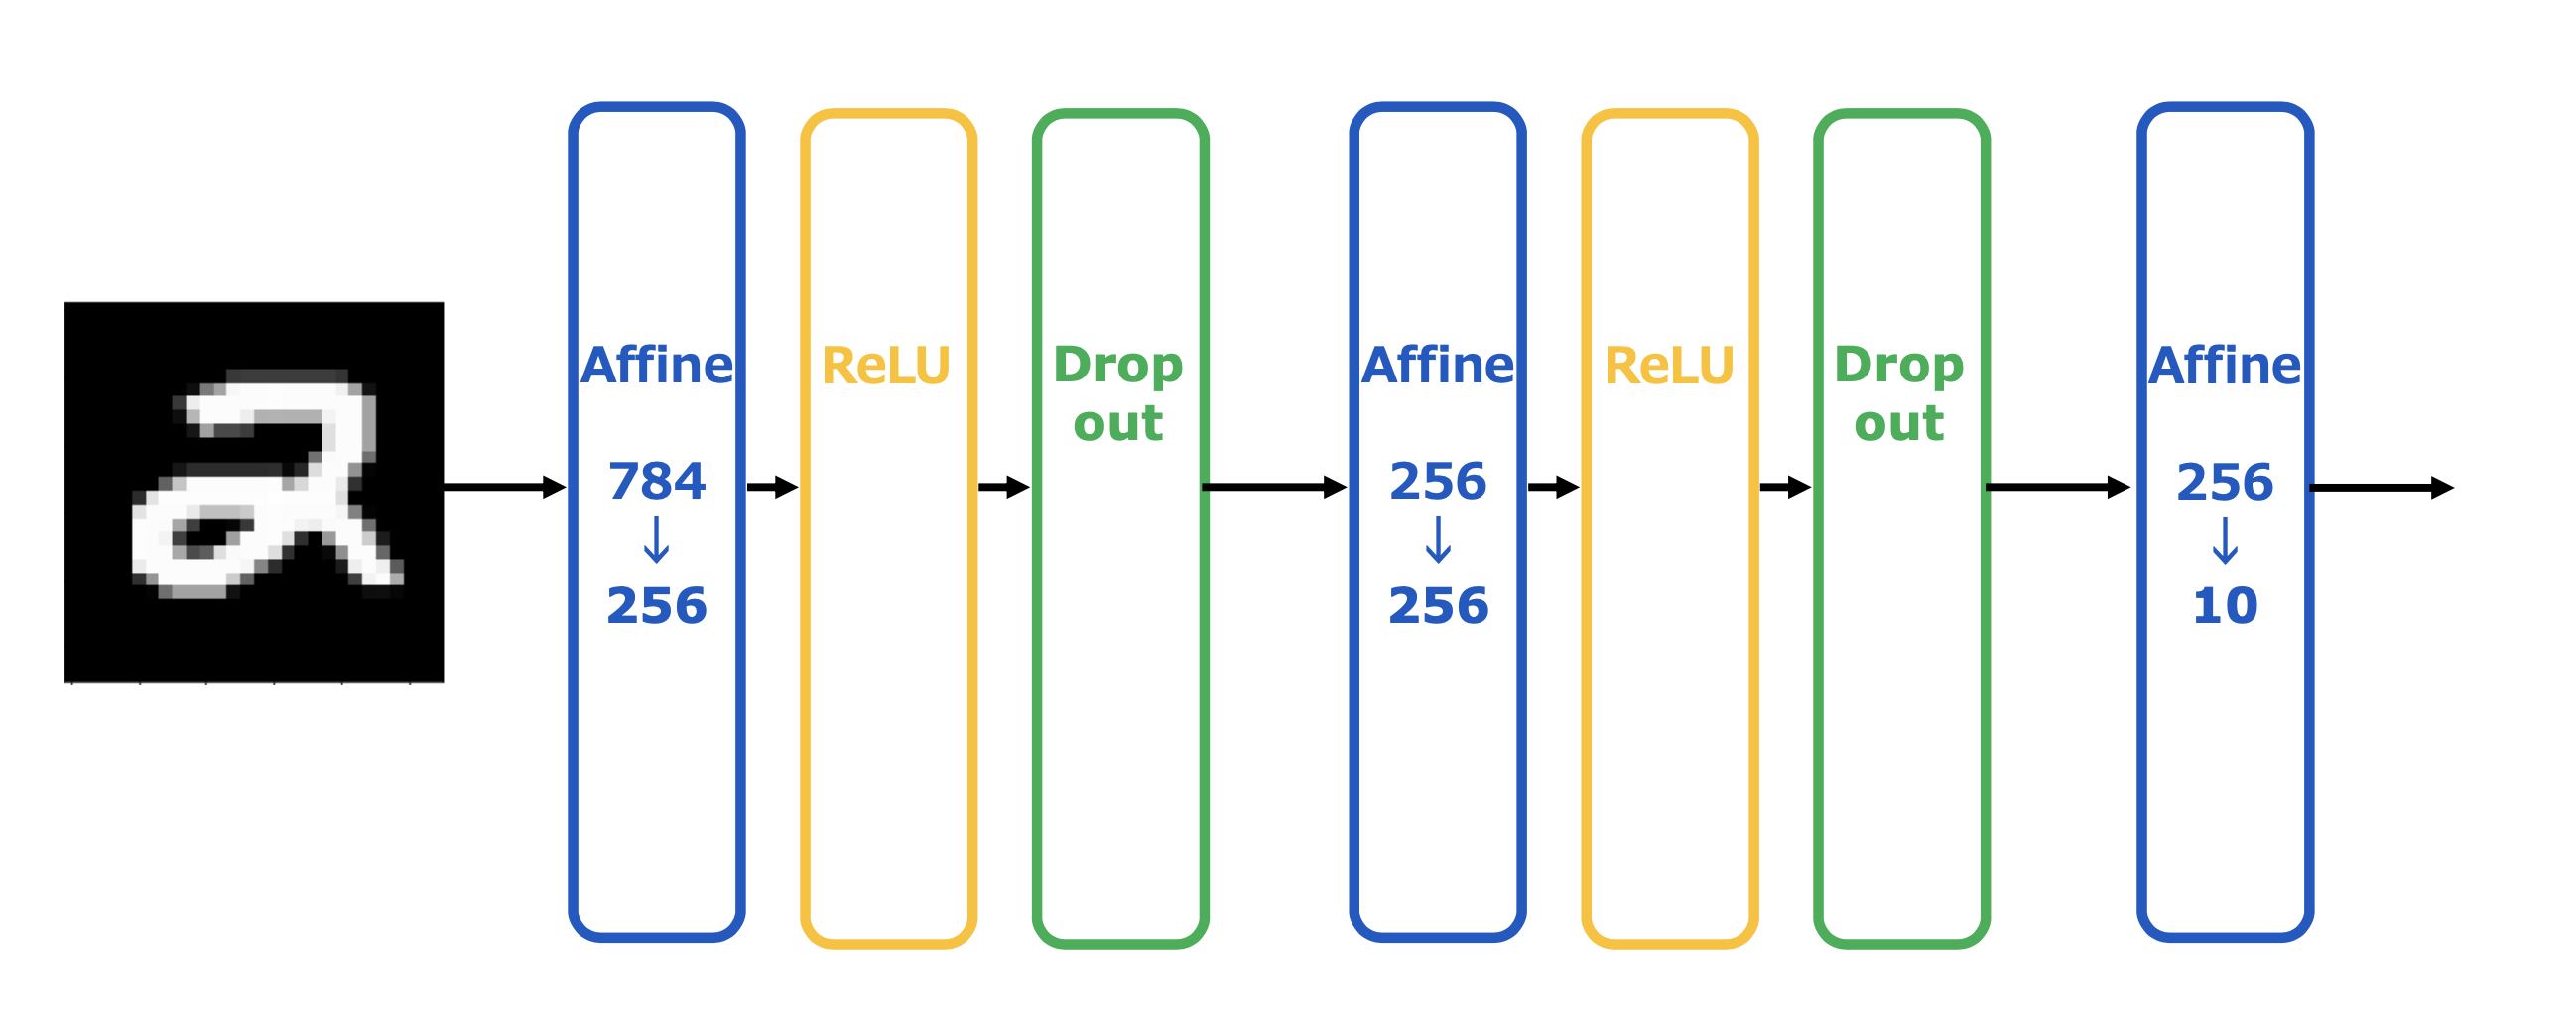


* <font color="Red">問6.ドロップアウトを含めたMLPクラスを完成させてください。</font><br>
    * <font color="Red">問6-1. 【forward関数】第1の全結合層の出力に対してドロップアウトを適用する処理を記述しましょう。</font><br>
    * <font color="Red">問6-2. 【forward関数】第2の全結合層の出力に対してドロップアウトを適用する処理を記述しましょう。</font><br>

In [26]:
class MLP_classifier(nn.Module):
    def __init__(self):
        '''
        構造
        x -> fc(784, 256) -> relu -> dropout -> fc(256, 256) -> relu -> dropout -> fc(256, 10) -> x
        '''
        super(MLP_classifier, self).__init__()
        # 層の定義
        self.fc1 = nn.Linear(784, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout()
        self.fc2 = nn.Linear(256, 256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout()
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        '''
        順伝播
        '''
        x = self.relu1(self.fc1(x))
        x =  ### 問6-1 ###
        x = self.relu2(self.fc2(x))
        x =  ### 問6-2 ###
        x = self.fc3(x)

        return x

### <font color="Red">ガイド</font>

問6-1、6-2ともに考え方は同じです。全結合層の出力は次のように表されます。

```
x = self.relu1(self.fc1(x))
```

従って、ドロップアウトに適用させる変数は```x```であることが分かります。

この変数をdropoutのインスタンスに通せば答えとなります。

------

### 学習
始めに、モデルや損失関数、最適化アルゴリズムを定義します。

* <font color="Red">問7. 問5で実装した`Ridge_loss`を使用して、損失関数に正則化項$\frac{\lambda}{2}\sqrt{{\sum_{n=1}^D{w_n^2}}}$を加えましょう。</font>

また、学習ステップとテストステップの手順を関数化します。

In [27]:
# モデルの宣言
model = MLP_classifier()
model.to(device)
# クロスエントロピー(損失関数)を定義
criterion = nn.CrossEntropyLoss()
# 最適化アルゴリズム
optimizer = torch.optim.Adam(model.parameters())

def compute_loss(y, t, criterion=criterion):
    loss =  #### 問7 ###
    return loss

def train_step(x,t,model,optimizer):
    model.train()
    preds = model(x)
    loss = compute_loss(preds, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds

def test_step(x,t,model):
    model.eval()
    preds = model(x)
    loss = compute_loss(preds, t)
    return loss, preds

### <font color="Red">ガイド</font>

まず、損失関数は```criterion = nn.CrossEntropyLoss()```を指します。また、正則化項は問題5で作成した```Ridge_loss```を指します。

次に、```criterion```に入力する引数についてです。```criterion```には２つの引数を持ちます。

```
criterion(input,target)

- input : 入力値（入力画像やデータ）
- target : 目的変数

```

今回の場合、```input```は```y```、```target```は```t```が該当します。

次に、```Ridge_loss```の引数は、正則化項を実装したいモデルなので、引数は```model```となります。

------

最後に学習ステップ`train_step`、テストステップ`test_step`を用いて学習と評価を行います。

accuracyが95%前後になっていれば学習成功です。

In [28]:
# 学習エポック数
epochs = 15
# epochs繰り返す
for epoch in range(epochs):

    train_loss = 0.
    test_loss = 0.
    train_acc = 0.
    test_acc = 0.

    for imgs, labels in train_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = train_step(imgs, labels, model, optimizer)
        train_loss += loss.item()
        train_acc += torch.sum(torch.argmax(preds, axis=1) == labels)
    train_loss /= len(train_dataloader)
    train_acc /= len(mnist_train)

    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = test_step(imgs, labels, model)
        test_loss += loss.item()
        test_acc += torch.sum(torch.argmax(preds, axis=1) == labels)
    test_loss /= len(test_dataloader)
    test_acc /= len(mnist_test)

    print(f'epoch: {epoch+1},train loss: {train_loss:.5f}, train acc: {train_acc:.5f}, test loss: {test_loss:.5f}, test acc: {test_acc:.5f}')

epoch: 1,train loss: 0.55029, train acc: 0.86678, test loss: 0.28960, test acc: 0.94860
epoch: 2,train loss: 0.34437, train acc: 0.93432, test loss: 0.25446, test acc: 0.96010
epoch: 3,train loss: 0.31159, train acc: 0.94547, test loss: 0.24115, test acc: 0.96360
epoch: 4,train loss: 0.29711, train acc: 0.94993, test loss: 0.22943, test acc: 0.96820
epoch: 5,train loss: 0.28967, train acc: 0.95260, test loss: 0.22189, test acc: 0.97100
epoch: 6,train loss: 0.28797, train acc: 0.95282, test loss: 0.22379, test acc: 0.97290
epoch: 7,train loss: 0.28082, train acc: 0.95585, test loss: 0.22422, test acc: 0.97190
epoch: 8,train loss: 0.28066, train acc: 0.95647, test loss: 0.21719, test acc: 0.97530
epoch: 9,train loss: 0.28039, train acc: 0.95722, test loss: 0.22087, test acc: 0.97370
epoch: 10,train loss: 0.27604, train acc: 0.95778, test loss: 0.22437, test acc: 0.97080
epoch: 11,train loss: 0.27525, train acc: 0.95795, test loss: 0.21384, test acc: 0.97510
epoch: 12,train loss: 0.27443,

## データ拡張（PyTorch）

始めに`rabbit.jpg`の画像を読み込み、表示しましょう。

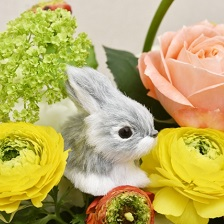

In [30]:
img = Image.open("rabbit.jpg")
display(img)

### Random Flip

Random Flipは画像を反転させるデータ拡張方法です。ここでは、`RandomHorizontalFlip`と`RandomVerticalFlip`を実装します。

`RandomHorizontalFlip`は水平方向に確率`p`に従って反転させます。

`RandomVerticalFlip`は垂直方向に確率`p`に従って反転させます。

`RandomHorizontalFlip`や`RandomVerticalFlip`は以下のような引数を持ちます。

```
【引数】
  p : 画像を反転させる確率 (ex. p=0.5)
```

分かりやすさのため、ここでは確率を1として必ず反転した画像を出力します。
* <font color="Red">問8-1. `transforms.RandomHorizontalFlip`を用いて、水平方向に確率`p=1`で反転させるデータ拡張を加えてください。</font>
* <font color="Red">問8-2. `transforms.RandomVerticalFlip`を用いて、垂直方向に確率`p=1`で反転させるデータ拡張を加えてください。</font>


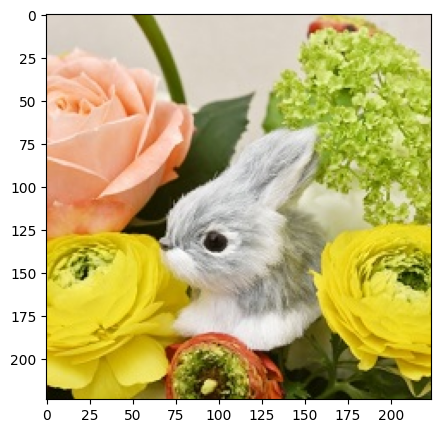

In [40]:
img = Image.open("rabbit.jpg")
transform=transforms.Compose([
     transforms.ToTensor(),
     ### 問8-1 ###
])
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img,(1,2,0))

plt.figure(figsize=(5, 5))
plt.imshow(img)

### <font color="Red">ガイド</font>

まず、```transforms.RandomHorizontalFlip```について説明します。

```RandomHorizontalFlip```とは、データを水平方向に反転させる関数です。

また、引数として```p```という値を入力すれば反転させるデータの割合を決められます。

```p```は0～1の実数値を取り、何も入力しないと```p=0.5```（50％の確率で反転する）で反転します。

今回は、```p=1```と指定されています。これは必ず反転させるという意味ですね。

------

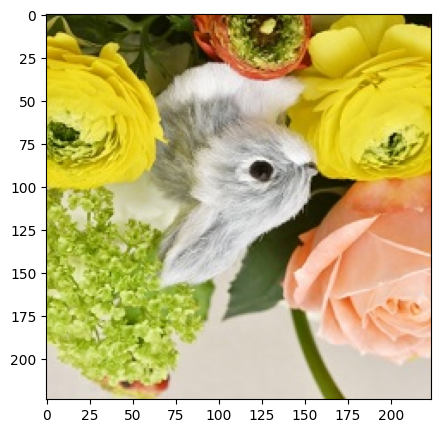

In [41]:
img = Image.open("rabbit.jpg")
transform=transforms.Compose([
     transforms.ToTensor(),
     ### 問8-2 ###
])
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img,(1,2,0))

plt.figure(figsize=(5, 5))
plt.imshow(img)

### <font color="Red">ガイド</font>

8-2では、```RandomVerticalFlip```を使用します。

```RandomVerticalFlip```とは、データを垂直方向に反転する関数です。```RandomHorizontalFlip```と同様に、反転させるデータの割合を決めることができます。

問題8-1と同じように考え、```p=1```と指定して関数を記述しましょう。

------

### Erase

Eraseの中でも、`RandomErasing`を実装します。

`RandomErasing`は画像の中の長方形領域をランダムに選択しそのピクセルを消去させるデータ拡張方法です。

`RandomErasing`は以下のような引数を持ちます。

```
【引数】
  p : 画像を反転させる確率 (ex. p=0.5)
  scale : 入力画像に対する消去領域の比率の範囲 (ex. scale=(0.05, 0.06))
  ratio : 消去領域のアスペクト比の範囲 (ex. ratio=(0.3, 3.0))
  value : 消去に関するパラメータで、RGBチャンネルをそれぞれ消去する際は、長さ3のタプルを指定 (ex. value=0)
```

分かりやすさのため、ここでは確率を1として必ずある一部分が消去された画像を出力します。

* <font color="Red">問9. `transforms.RandomErasing`を用いて、確率`p=1`で画像内の長方形領域をランダムにピクセル消去させるデータ拡張を加えてください。ただし、以下の条件を満たしてください。</font>
  * <font color="Red">入力画像に対する消去領域の比率の範囲を(0.02, 0.33)とします。</font>
  * <font color="Red">消去領域のアスペクト比の範囲を(0.3, 3.3)とします。</font>
  * <font color="Red">消去領域の色は黒(=0)とします。</font>

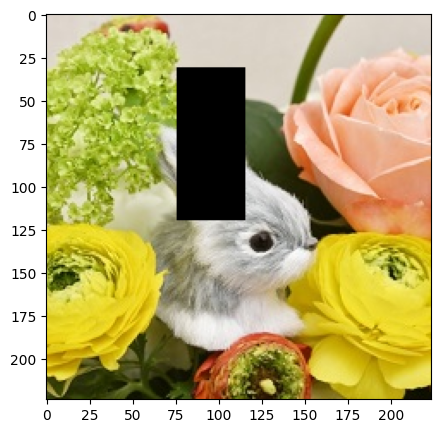

In [33]:
img = Image.open("rabbit.jpg")
transform=transforms.Compose([
     transforms.ToTensor(),
     ### 問9 ###
])
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img,(1,2,0))

plt.figure(figsize=(5, 5))
plt.imshow(img)

### <font color="Red">ガイド</font>

transformsというライブラリの中には、```RandomErasing```という関数があります。

```RandomErasing```とは、画像内からランダムに長方形領域を選択し、選択した領域を虫食い状態にする（隠す）実装を行う関数です。

```RandomErasing```には以下のような引数があります。

- ```p``` : ```RandomErasing```を実装する割合
- ```scale``` : 入力画像に対する消去領域の比率の範囲
- ```ratio``` : 消去領域のアスペクト比の範囲
- ```value``` : 消去領域の色（0の場合は黒）

今回は、問題にそれぞれの引数が指定されているため、それらを対応させたものが答えとなります。

------

### Crop

Cropsは画像の切り取りによって得られるデータ拡張方法です。Cropsの中でも、`CenterCrop`を実装します。`CenterCrop`は与えられた画像を中央で切り取ります。

`CenterCrop`は以下のような引数を持ちます。

```
【引数】
  size : 切り取るサイズ (ex. size=300, size=(200, 300))
```

* <font color="Red">問10. `transforms.CenterCrop`を用いて、画像の中央を(224, 224)のサイズで切り取るデータ拡張を加えてください。</font>

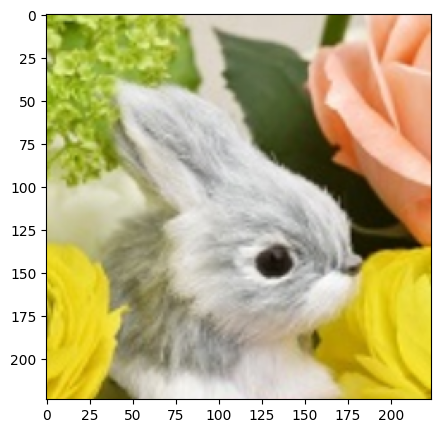

In [34]:
img = Image.open("rabbit.jpg")
transform=transforms.Compose(
    [transforms.Resize(350),
     ### 問10 ###
     transforms.ToTensor()
     ]
)
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img,(1,2,0))

plt.figure(figsize=(5, 5))
plt.imshow(img)

### <font color="Red">ガイド</font>

transformsというライブラリの中には、```CenterCrop```という関数が入っています。```CenterCrop```とは、画像の中央部分を切り取る関数です。

引数として、中央部分を中心として、どれくらいの大きさを切り取るかという変数を入力することができます。

今回は、(224,224)というサイズが指定されているため、そのまま適用しましょう。

### Brightness

Brightnessは画像の明るさを変更させることによって得られるデータ拡張方法です。Brightnessの中でも、`ColorJitter`を実装します。`ColorJitter`は画像の明るさ、コントラスト、彩度、色合いをランダムに変化させます。<br>

`ColorJitter`は以下のような引数を持ちます。

```
【引数】
  brightness : 明るさを調整するパラメータ (ex. brightness=0.80)
  contrast : コントラストを調整するパラメータ (ex. contrast=0.80)
  saturation : 彩度を調整するパラメータ (ex. saturation=0.80)
  hue : 色合いを調整するパラメータ (ex. hue=0.60)
```

* <font color="Red">問11. `transforms.ColorJitter`を用いて、画像の明るさを変更させるデータ拡張を加えましょう。ただし、以下の条件を満たしてください。</font>
  * <font color="Red">明るさを0.75とします</font>
  * <font color="Red">コントラストを0.75とします</font>
  * <font color="Red">彩度を0.75とします</font>
  * <font color="Red">色合いを0.5とします</font>

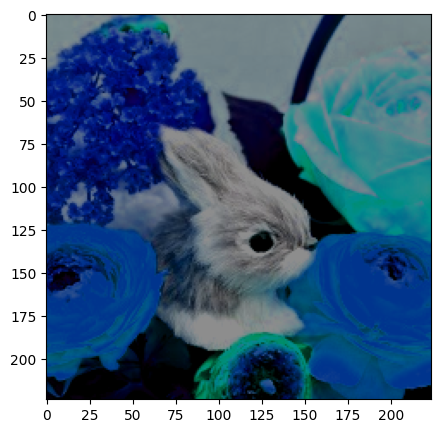

In [35]:
img = Image.open("rabbit.jpg")
transform=transforms.Compose([
     transforms.ToTensor(),
     ### 問11 ###
])
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img,(1,2,0))

plt.figure(figsize=(5, 5))
plt.imshow(img)

### <font color="Red">ガイド</font>

ここでは```ColorJitter```という関数を利用します。

```ColorJitter```とは、色の明るさ、コントラスト、彩度、色合いを変えることができる関数となっております。

引数は以下の4つです。

- ```brightness``` : 明るさ
- ```contrast``` : コントラスト
- ```saturation``` : 彩度
- ```hue``` : 色合い

それぞれの引数に入力する値については、問題文に書かれているため、これを入力すればOKです。

### Rotate

Rotateは画像を回転させることによって得られるデータ拡張方法です。Rotateの中でも、`RandomRotation`を実装します。`RandomRotation`はランダムに画像を回転させます。

`RandomRotation`は以下のような引数を持ちます。

```
【引数】
  degrees : 選択する角度の範囲を指定するパラメータ (ex. degrees=60)
  expand : 拡張を実行するか決定するパラメータ。
           trueの場合、出力を拡大して、回転した画像全体を格納できる大きさにし、
           falseまたは省略された場合は、出力画像を入力画像と同じ大きさにする。
  fill : 回転した画像の外側の領域を埋める値 (ex. fill=255)
```

* <font color="Red">問12. `transforms.RandomRotation`を用いて、画像を-90~90度回転させるデータ拡張を加えましょう。回転した画像の外側は黒色(=0)とし、出力画像は入力画像と同じ大きさにします。</font>

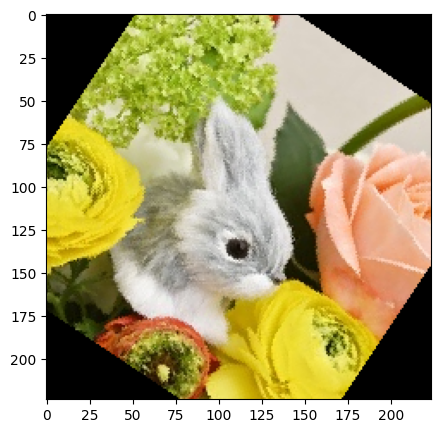

In [36]:
img = Image.open("rabbit.jpg")
transform=transforms.Compose([
     transforms.ToTensor(),
     ### 問12 ###
])
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img,(1,2,0))

plt.figure(figsize=(5, 5))
plt.imshow(img)

### <font color="Red">ガイド</font>

今回は、```RandomRotation```を利用します。

```RandomRotation```とは、ランダムにデータ（画像）を回転させることができる関数です。

引数は以下の3つです。

```
- degrees : 選択する角度の範囲を指定するパラメータ
- expand : 拡張を実行するか決定するパラメータ。
           trueの場合、出力を拡大して、回転した画像全体を格納できる大きさにし、
           falseまたは省略された場合は、出力画像を入力画像と同じ大きさにする。
- fill : 彩度
```

また、それぞれの引数に入力する値については、問題文に書かれています。

-90~90度回転（```degrees=90```）、回転した画像の外側は黒色（```fill=0```）、出力画像は入力画像と同じ大きさ（```expand=False```）ということが分かります。

------

### MixUp

MixUpは2つの学習サンプルを混合して新たな学習サンプルを作成するデータ拡張手法です。

データとラベルのペア$(X_1, y_1)$と$(X_2, y_2)$から新たな学習サンプル$(X, y)$を作成します。ラベル$y_1, y_2$がone-hot表現の時、以下の式で$(X, y)$を作成します。

$$
X = \lambda X_1 + (1 - \lambda)X_2
$$
$$
y = \lambda y_1 + (1 - \lambda)y_2
$$

ここで、$\lambda$は0~1の範囲を取るパラメータで、ベータ分布$\beta(x,\alpha, \alpha)$からランダムにサンプリングします。$\alpha$はハイパーパラメータです。<br>
ベータ分布は以下のような確率密度関数として表すことができる。$C$は正規化定数。
$$
\beta(x,a,b) = C x ^ {a-1}(1-x) ^ {b-1}(0\leqq x\leqq 1)
$$


* <font color="Red">問13. MixUpにより新たな学習サンプルを作成しましょう。</font>
  * <font color="Red">問13-1. `np.random.beta()`関数を用いてベータ分布$\beta(\alpha, \alpha)$からサンプリングしましょう。</font>
  * <font color="Red">問13-2. パラメータ`lam`, 学習サンプル`x`, `x[index,:]`を使用して新たな学習データを算出する式を記述してください。</font>

In [37]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [38]:
torch.manual_seed(0)
np.random.seed(0)
transform=transforms.Compose(
    [transforms.ToTensor(),
     ]
)
dataset = datasets.MNIST('../data', train=False, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

def mixup_data(x, y, alpha=1.0, use_cuda=True):

    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = ### 問13-1 ###
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = ### 問13-2 ###
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



target_a : 7
target_b : 6
mixed_target_vector: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6294, 0.3706, 0.0000,
        0.0000])
lambda : 0.37061547061658573


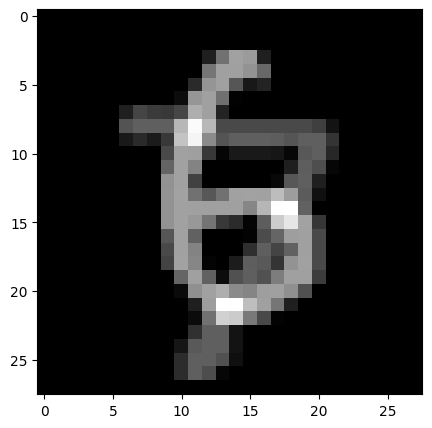

target_a : 3
target_b : 4
mixed_target_vector: tensor([0.0000, 0.0000, 0.0000, 0.5503, 0.4497, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
lambda : 0.5503058575303685


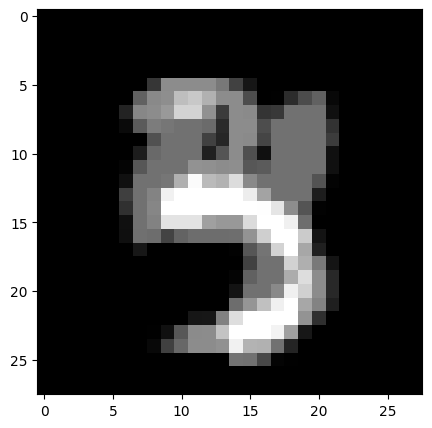

target_a : 7
target_b : 3
mixed_target_vector: tensor([0.0000, 0.0000, 0.0000, 0.6992, 0.0000, 0.0000, 0.0000, 0.3008, 0.0000,
        0.0000])
lambda : 0.30081220227043654


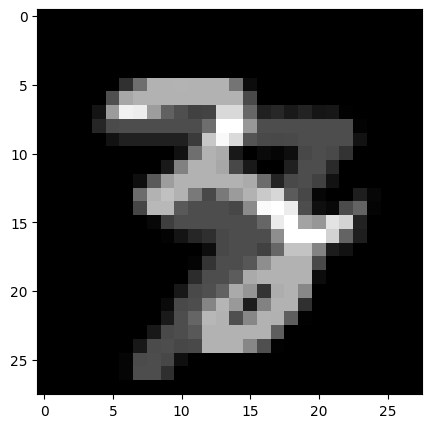

In [39]:
counter = 0
for data, label in dataloader:
    mixed_data, target_a, target_b, lam = mixup_data(data, label, alpha=0.5, use_cuda=torch.cuda.is_available())
    counter += 1
    print(f'target_a : {target_a[0]}')
    print(f'target_b : {target_b[0]}')
    onehot_target_a = torch.eye(10)[target_a]
    onehot_target_b = torch.eye(10)[target_b]
    mixed_target_vector = onehot_target_a * lam + onehot_target_b * (1-lam)
    print(f'mixed_target_vector: {mixed_target_vector[0]}')
    print(f'lambda : {lam}')    
    img = mixed_data.numpy()[0].reshape((28, 28))
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.show()
    if counter == 3:
        break

### <font color="Red">ガイド</font>

```Mixup```は対応する関数が無いので、既存の関数の組み合わせで作ります。

#### ベータ分布

Mixupのパラメータはベータ分布の乱数からサンプリングします。

ベータ分布の乱数は```np.random.beta```で生成可能で、パラメータを2つ指定します。

この指定パラメータを両方```alpha```にすればOKです。

#### 学習データ生成

新たな学習データは以下の式で生成されます。

$$
X = \lambda X_1 + (1 - \lambda)X_2
$$

```lam```は問13-1で計算したパラメータで、$X_1$はデータ```x```、$X_2$はデータ```x[index,:]```を指します。

これをそのままコードに当てはめればOKです。